# 1. MODEL GEMMA2

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

VER=1
#model_name = "google/gemma-2-9b-it"
model_name = "/kaggle/input/gemma2-9b-it-cv945"
EPOCHS = 2

DIR = f"ver_{VER}"
os.makedirs(DIR, exist_ok=True)

In [2]:
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train.csv')
train.Misconception = train.Misconception.fillna('NA')
train['target'] = train.Category+":"+train.Misconception
train['label'] = le.fit_transform(train['target'])
target_classes = le.classes_
n_classes = len(target_classes)
print(f"Train shape: {train.shape} with {n_classes} target classes")
train.head()

Train shape: (36696, 9) with 65 target classes


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37


In [3]:
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

In [4]:
from IPython.display import display, Math, Latex

# GET ANSWER CHOICES
tmp = train.groupby(['QuestionId','MC_Answer']).size().reset_index(name='count')
tmp['rank'] = tmp.groupby('QuestionId')['count'].rank(method='dense', ascending=False).astype(int) - 1
tmp = tmp.drop('count',axis=1)
tmp = tmp.sort_values(['QuestionId','rank'])

# DISPLAY QUESTION AND ANSWER CHOICES
Q = tmp.QuestionId.unique()
for q in Q:
    question = train.loc[train.QuestionId==q].iloc[0].QuestionText
    choices = tmp.loc[tmp.QuestionId==q].MC_Answer.values
    labels="ABCD"
    choice_str = " ".join([f"({labels[i]}) {choice}" for i, choice in enumerate(choices)])
    
    print()
    display(Latex(f"QuestionId {q}: {question}") )
    display(Latex(f"MC Answers: {choice_str}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(model_name)
MAX_LEN = 256

In [6]:
def format_input(row):
    x = "Yes"
    if not row['is_correct']:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct? {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[0] )

Example prompt for our LLM:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct? Yes
Student Explanation: 0ne third is equal to tree nineth


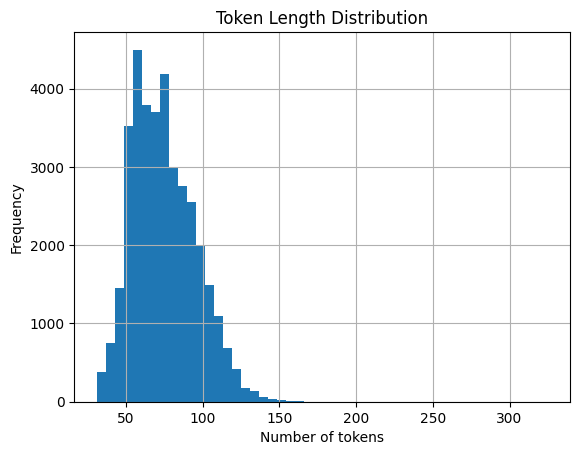

In [7]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [8]:
L = (np.array(lengths)>MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort( lengths )

There are 1 train sample(s) with more than 256 tokens


array([ 31,  31,  31, ..., 195, 231, 325])

In [9]:
# Split into train and validation sets
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
COLS = ['text','label']
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [10]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/input/gemma2-9b-it-bf16",
    num_labels=n_classes,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

2025-08-25 02:18:20.701759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756088301.043112      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756088301.142640      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/gemma2-9b-it-bf16 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from peft import PeftModel
model = PeftModel.from_pretrained(model, model_name)

/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['qalora_group_size', 'use_qalora'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


In [13]:
training_args = TrainingArguments(
    output_dir = f"./{DIR}",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps", #no for no saving 
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
    bf16=False, # TRAIN WITH BF16 IF LOCAL GPU IS NEWER GPU          
    fp16=True, # INFER WITH FP16 BECAUSE KAGGLE IS T4 GPU
)

In [14]:
# CUSTOM MAP@3 METRIC

from sklearn.metrics import average_precision_score

def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    
    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

In [15]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_map3,
)

#trainer.train()

/tmp/ipykernel_19/661334471.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [16]:
#trainer.save_model(f"ver_{VER}")      
#tokenizer.save_pretrained(f"ver_{VER}")

In [17]:
test = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/test.csv')
print( test.shape )
test.head()

(3, 5)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


In [18]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)

test['text'] = test.apply(format_input,axis=1)

test.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\nAnswe...


In [19]:
ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)

predictions = trainer.predict(ds_test)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [20]:
# Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = ["|".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission_gemma.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA|True_Neither:NA|True_Misconcep...
1,36697,False_Misconception:WNB|False_Neither:NA|True_...
2,36698,True_Neither:NA|True_Correct:NA|True_Misconcep...


In [21]:
sub.iloc[0]['Category:Misconception']

'True_Correct:NA|True_Neither:NA|True_Misconception:Incomplete|True_Misconception:Wrong_fraction|True_Misconception:Wrong_term|False_Misconception:Incomplete|True_Misconception:Inversion|True_Misconception:Duplication|True_Misconception:Denominator-only_change|False_Correct:NA|True_Misconception:SwapDividend|False_Misconception:Wrong_fraction|True_Misconception:Irrelevant|True_Misconception:Tacking|True_Misconception:Mult|True_Misconception:FlipChange|True_Misconception:Positive|True_Misconception:Multiplying_by_4|True_Misconception:Division|True_Misconception:Definition|True_Misconception:Subtraction|True_Misconception:WNB|True_Misconception:Adding_across|True_Misconception:Not_variable|True_Misconception:Firstterm|True_Misconception:Shorter_is_bigger|True_Misconception:Incorrect_equivalent_fraction_addition|False_Misconception:Division|True_Misconception:Whole_numbers_larger|True_Misconception:Additive|False_Misconception:Incorrect_equivalent_fraction_addition|False_Misconception:Inv

In [22]:
import torch
import gc

del top3_labels, flat_top3, decoded_labels, top3, test, ds_test
del training_args, train_ds, val_ds, model, trainer, predictions, probs
# Delete any other lingering references
for obj in list(globals().keys()):
    if isinstance(globals()[obj], torch.nn.Module) or isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]

# Dọn sạch autograd
torch.cuda.empty_cache()
gc.collect()

# Nếu dùng nhiều GPU, làm thêm bước này để clear hết:
torch.cuda.ipc_collect()

# In ra kiểm tra
print("Memory allocated:", torch.cuda.memory_allocated())
print("Memory reserved:", torch.cuda.memory_reserved())

Memory allocated: 8519680
Memory reserved: 9030336512


In [23]:
# Delete any other lingering references
for obj in list(globals().keys()):
    if isinstance(globals()[obj], torch.nn.Module) or isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]

# Dọn sạch autograd
torch.cuda.empty_cache()
gc.collect()

# Nếu dùng nhiều GPU, làm thêm bước này để clear hết:
torch.cuda.ipc_collect()

# In ra kiểm tra
print("Memory allocated:", torch.cuda.memory_allocated())
print("Memory reserved:", torch.cuda.memory_reserved())

Memory allocated: 8519680
Memory reserved: 12582912


In [24]:
# Delete any other lingering references
for obj in list(globals().keys()):
    if isinstance(globals()[obj], torch.nn.Module) or isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]

# Dọn sạch autograd
torch.cuda.empty_cache()
gc.collect()

# Nếu dùng nhiều GPU, làm thêm bước này để clear hết:
torch.cuda.ipc_collect()

# In ra kiểm tra
print("Memory allocated:", torch.cuda.memory_allocated())
print("Memory reserved:", torch.cuda.memory_reserved())

Memory allocated: 8519680
Memory reserved: 12582912


In [25]:
# Delete any other lingering references
for obj in list(globals().keys()):
    if isinstance(globals()[obj], torch.nn.Module) or isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]

# Dọn sạch autograd
torch.cuda.empty_cache()
gc.collect()

# Nếu dùng nhiều GPU, làm thêm bước này để clear hết:
torch.cuda.ipc_collect()

# In ra kiểm tra
print("Memory allocated:", torch.cuda.memory_allocated())
print("Memory reserved:", torch.cuda.memory_reserved())

Memory allocated: 8519680
Memory reserved: 12582912


# 2. DEEPSEEK MATH

In [26]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, ModernBertForSequenceClassification, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from datasets import Dataset


In [28]:
train               = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train.csv')
test                = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/test.csv')


In [29]:
le                  = LabelEncoder()
train.Misconception     = train.Misconception.fillna('NA')
train['target']   = train.Category + ':' +train.Misconception
train['label']    = le.fit_transform(train['target'])

n_classes = len(le.classes_)
print(f"Train shape: {train.shape} with {n_classes} target classes")

Train shape: (36696, 9) with 65 target classes


In [30]:
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)


In [31]:


test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)



In [32]:
def format_input(row):
    x = "This answer is correct."
    if not row['is_correct']:
        x = "This is answer is incorrect."
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"{x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

test['text'] = test.apply(format_input,axis=1)

In [33]:
ds_test = Dataset.from_pandas(test)

In [34]:


model = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/deekseepmath-7b-map-competition/MAP_EXP_09_FULL", device_map="cuda:0", torch_dtype=torch.bfloat16)



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [35]:


tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/deekseepmath-7b-map-competition/MAP_EXP_09_FULL")
model.config.pad_token_id = tokenizer.pad_token_id

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

ds_test = ds_test.map(tokenize, batched=True)



Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [36]:


test_args = TrainingArguments(
    output_dir="./",
    do_train=False,
    do_predict=True,
    per_device_eval_batch_size=16, # Adjust as needed
    bf16=False, # TRAIN WITH BF16 IF LOCAL GPU IS NEWER GPU          
    fp16=True,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=test_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

predictions = trainer.predict(ds_test)

predictions.predictions



/tmp/ipykernel_19/1508544383.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


array([[ 0.5       , -2.203125  , -2.34375   , -2.53125   , -2.03125   ,
        -0.82421875, -2.28125   , -1.5546875 , -2.015625  , -0.8203125 ,
        -2.046875  , -1.2109375 , -2.890625  , -1.046875  , -1.8671875 ,
        -2.21875   , -2.453125  , -1.9453125 , -1.1328125 , -1.3125    ,
        -1.109375  , -1.046875  , -1.046875  , -1.25      , -1.5703125 ,
        -2.640625  , -1.09375   , -2.890625  , -2.359375  , -1.4296875 ,
        -1.234375  , -1.21875   , -1.4609375 , -1.90625   , -1.2421875 ,
        -1.40625   , -0.6015625 , 11.1875    , -2.3125    , -0.31054688,
        -2.375     , -1.5234375 ,  0.58203125, -0.4375    ,  1.015625  ,
        -1.0078125 , -1.34375   ,  2.328125  , -1.75      , -0.22070312,
         0.04980469, -2.640625  ,  0.11669922, -0.06787109, -2.1875    ,
        -0.890625  ,  0.6796875 , -2.5625    ,  0.78515625, -1.5       ,
         0.11914062, -1.953125  ,  0.30078125, -0.01977539,  5.96875   ],
       [ 0.9140625 , -1.3671875 , -1.96875   , -0.

In [37]:


top3           = np.argsort(-predictions.predictions, axis=1)[:, :]
flat_top3      = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels_cat    = decoded_labels.reshape(top3.shape)
top3_labels_cat



array([['True_Correct:NA', 'True_Neither:NA',
        'True_Misconception:Incomplete',
        'True_Misconception:Duplication',
        'True_Misconception:SwapDividend',
        'True_Misconception:Shorter_is_bigger',
        'True_Misconception:Denominator-only_change', 'False_Correct:NA',
        'True_Misconception:Wrong_fraction', 'True_Misconception:WNB',
        'True_Misconception:Mult', 'True_Misconception:Irrelevant',
        'True_Misconception:Wrong_term',
        'True_Misconception:Multiplying_by_4',
        'True_Misconception:Inversion', 'True_Misconception:Additive',
        'True_Misconception:Division', 'False_Neither:NA',
        'False_Misconception:Duplication',
        'False_Misconception:Certainty', 'True_Misconception:Positive',
        'True_Misconception:Firstterm',
        'False_Misconception:Not_variable',
        'False_Misconception:Incomplete',
        'False_Misconception:Multiplying_by_4',
        'False_Misconception:Subtraction', 'False_Misconcept

In [38]:


joined_preds = []

for preds in top3_labels_cat:
    joined_preds.append("|".join(preds))



# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission_deepseek.csv", index=False)
sub.head()



,row_id,Category:Misconception
0,36696,True_Correct:NA|True_Neither:NA|True_Misconcep...
1,36697,False_Misconception:WNB|False_Neither:NA|False...
2,36698,True_Neither:NA|True_Correct:NA|True_Misconcep...


In [39]:
sub.iloc[0]['Category:Misconception']

'True_Correct:NA|True_Neither:NA|True_Misconception:Incomplete|True_Misconception:Duplication|True_Misconception:SwapDividend|True_Misconception:Shorter_is_bigger|True_Misconception:Denominator-only_change|False_Correct:NA|True_Misconception:Wrong_fraction|True_Misconception:WNB|True_Misconception:Mult|True_Misconception:Irrelevant|True_Misconception:Wrong_term|True_Misconception:Multiplying_by_4|True_Misconception:Inversion|True_Misconception:Additive|True_Misconception:Division|False_Neither:NA|False_Misconception:Duplication|False_Misconception:Certainty|True_Misconception:Positive|True_Misconception:Firstterm|False_Misconception:Not_variable|False_Misconception:Incomplete|False_Misconception:Multiplying_by_4|False_Misconception:Subtraction|False_Misconception:Mult|False_Misconception:Irrelevant|False_Misconception:FlipChange|False_Misconception:Whole_numbers_larger|False_Misconception:WNB|False_Misconception:Wrong_fraction|False_Misconception:Positive|False_Misconception:Longer_is_

In [40]:
import torch
import gc

del top3_labels_cat, flat_top3, decoded_labels, top3, test, ds_test
del test_args, model, trainer, predictions
# Delete any other lingering references
for obj in list(globals().keys()):
    if isinstance(globals()[obj], torch.nn.Module) or isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]

# Dọn sạch autograd
torch.cuda.empty_cache()
gc.collect()

# Nếu dùng nhiều GPU, làm thêm bước này để clear hết:
torch.cuda.ipc_collect()

# In ra kiểm tra
print("Memory allocated:", torch.cuda.memory_allocated())
print("Memory reserved:", torch.cuda.memory_reserved())

Memory allocated: 17039360
Memory reserved: 12991856640


In [41]:
for obj in list(globals().keys()):
    if isinstance(globals()[obj], torch.nn.Module) or isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]

# Dọn sạch autograd
torch.cuda.empty_cache()
gc.collect()

# Nếu dùng nhiều GPU, làm thêm bước này để clear hết:
torch.cuda.ipc_collect()

# In ra kiểm tra
print("Memory allocated:", torch.cuda.memory_allocated())
print("Memory reserved:", torch.cuda.memory_reserved())

Memory allocated: 17039360
Memory reserved: 12991856640


In [42]:
for obj in list(globals().keys()):
    if isinstance(globals()[obj], torch.nn.Module) or isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]

# Dọn sạch autograd
torch.cuda.empty_cache()
gc.collect()

# Nếu dùng nhiều GPU, làm thêm bước này để clear hết:
torch.cuda.ipc_collect()

# In ra kiểm tra
print("Memory allocated:", torch.cuda.memory_allocated())
print("Memory reserved:", torch.cuda.memory_reserved())

Memory allocated: 17039360
Memory reserved: 12991856640


In [43]:
for obj in list(globals().keys()):
    if isinstance(globals()[obj], torch.nn.Module) or isinstance(globals()[obj], torch.Tensor):
        del globals()[obj]

# Dọn sạch autograd
torch.cuda.empty_cache()
gc.collect()

# Nếu dùng nhiều GPU, làm thêm bước này để clear hết:
torch.cuda.ipc_collect()

# In ra kiểm tra
print("Memory allocated:", torch.cuda.memory_allocated())
print("Memory reserved:", torch.cuda.memory_reserved())

Memory allocated: 17039360
Memory reserved: 12991856640


# 3. Gemma3 8B

In [44]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, ModernBertForSequenceClassification, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [46]:
train               = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train.csv')
test                = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/test.csv')

In [47]:
le                  = LabelEncoder()
train.Misconception     = train.Misconception.fillna('NA')
train['target']   = train.Category + ':' +train.Misconception
train['label']    = le.fit_transform(train['target'])

n_classes = len(le.classes_)
print(f"Train shape: {train.shape} with {n_classes} target classes")

Train shape: (36696, 9) with 65 target classes


In [48]:
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

In [49]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)


In [50]:
def format_input(row):
    x = "This answer is correct."
    if not row['is_correct']:
        x = "This is answer is incorrect."
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"{x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

test['text'] = test.apply(format_input,axis=1)

In [51]:
ds_test = Dataset.from_pandas(test)

In [52]:
model = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/qwen3-8b-map-competition/MAP_EXP_16_FULL", device_map="cuda:1", torch_dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [53]:
model


Qwen3ForSequenceClassification(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
        (post_attentio

In [54]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/qwen3-8b-map-competition/MAP_EXP_16_FULL")
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

ds_test = ds_test.map(tokenize, batched=True)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [55]:
test_args = TrainingArguments(
    output_dir="./",
    do_train=False,
    do_predict=True,
    per_device_eval_batch_size=1, # Adjust as needed
    bf16=False, # TRAIN WITH BF16 IF LOCAL GPU IS NEWER GPU          
    fp16=True,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=test_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

predictions = trainer.predict(ds_test)

predictions.predictions

/tmp/ipykernel_19/1882862596.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


array([[-0.5917969 , -1.203125  , -1.8378906 , -5.1210938 , -1.4160156 ,
        -1.9462891 , -3.0878906 , -1.1455078 , -1.5546875 , -2.0859375 ,
        -2.0722656 , -1.9472656 , -2.4023438 ,  0.09143066, -2.3847656 ,
        -2.7363281 , -2.        , -1.7636719 , -2.5761719 , -3.2539062 ,
        -1.1259766 , -2.0507812 , -2.1679688 , -1.7246094 , -1.4677734 ,
        -3.2558594 ,  0.16394043, -2.5898438 , -3.9628906 , -2.0585938 ,
        -1.9960938 , -1.1503906 , -2.0117188 , -3.2011719 , -1.9042969 ,
        -1.4375    , -1.8359375 , 11.9921875 , -1.2832031 , -0.5957031 ,
        -4.6523438 , -1.6435547 ,  2.0371094 , -0.62597656,  0.7109375 ,
         0.43188477, -0.81933594,  4.2773438 , -2.53125   ,  0.9970703 ,
         1.4169922 , -2.5703125 , -0.29833984, -1.1210938 , -1.7441406 ,
        -0.5024414 ,  0.6665039 , -1.3164062 , -0.3154297 ,  0.8051758 ,
         0.84814453, -2.3144531 ,  0.9824219 ,  0.6645508 ,  6.9726562 ],
       [ 1.1054688 , -2.2421875 , -1.6552734 , -1.

In [56]:
top3           = np.argsort(-predictions.predictions, axis=1)[:, :]
flat_top3      = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels_cat    = decoded_labels.reshape(top3.shape)
top3_labels_cat


array([['True_Correct:NA', 'True_Neither:NA',
        'True_Misconception:Incomplete',
        'True_Misconception:Denominator-only_change',
        'True_Misconception:Irrelevant', 'True_Misconception:Inversion',
        'True_Misconception:Wrong_fraction', 'True_Misconception:WNB',
        'True_Misconception:Tacking', 'True_Misconception:Duplication',
        'True_Misconception:Shorter_is_bigger',
        'True_Misconception:Wrong_term', 'True_Misconception:Firstterm',
        'False_Misconception:Subtraction',
        'False_Misconception:Incomplete', 'True_Misconception:Mult',
        'True_Misconception:SwapDividend', 'True_Misconception:Positive',
        'False_Correct:NA', 'True_Misconception:Additive',
        'True_Misconception:Division', 'True_Misconception:FlipChange',
        'True_Misconception:Multiplying_by_4',
        'False_Misconception:Mult',
        'False_Misconception:Denominator-only_change',
        'False_Misconception:Whole_numbers_larger',
        'False_

In [57]:


joined_preds = []

for preds in top3_labels_cat:
    joined_preds.append("|".join(preds))



# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission_gemma3.csv", index=False)
sub.head()



,row_id,Category:Misconception
0,36696,True_Correct:NA|True_Neither:NA|True_Misconcep...
1,36697,False_Misconception:WNB|False_Misconception:In...
2,36698,True_Neither:NA|True_Correct:NA|True_Misconcep...


In [58]:
sub.iloc[0]['Category:Misconception']

'True_Correct:NA|True_Neither:NA|True_Misconception:Incomplete|True_Misconception:Denominator-only_change|True_Misconception:Irrelevant|True_Misconception:Inversion|True_Misconception:Wrong_fraction|True_Misconception:WNB|True_Misconception:Tacking|True_Misconception:Duplication|True_Misconception:Shorter_is_bigger|True_Misconception:Wrong_term|True_Misconception:Firstterm|False_Misconception:Subtraction|False_Misconception:Incomplete|True_Misconception:Mult|True_Misconception:SwapDividend|True_Misconception:Positive|False_Correct:NA|True_Misconception:Additive|True_Misconception:Division|True_Misconception:FlipChange|True_Misconception:Multiplying_by_4|False_Misconception:Mult|False_Misconception:Denominator-only_change|False_Misconception:Whole_numbers_larger|False_Misconception:Adding_across|True_Misconception:Adding_across|True_Misconception:Subtraction|False_Misconception:Base_rate|False_Misconception:Wrong_term|False_Misconception:Scale|False_Misconception:Division|True_Misconcep

# 4. ENSEMBLE EVERYTHING

In [59]:
from collections import defaultdict
import math

def bayesian_model_averaging(lists):
    elements = set()
    for lst in lists:
        elements.update(lst)
    elements = list(elements)
    n = len(elements)
    element_to_index = {elem: i for i, elem in enumerate(elements)}

    # 初始化得分
    score = defaultdict(float)
    total_weight = 0

    # 计算每个模型的权重
    for lst in lists:
        weight = 1 / math.sqrt(len(lst))  # 示例权重计算方式
        total_weight += weight
        for rank, item in enumerate(lst):
            score[item] += weight * (n - rank)

    # 归一化得分
    for item in score:
        score[item] /= total_weight

    # 返回排序结果
    sorted_items = sorted(score.items(), key=lambda x: -x[1])
    return [item for item, _ in sorted_items]

def get_top_k_ensemble(l1, l2,l3, k=3):
    lists = [l1.split('|'), l2.split('|'),l3.split('|')]
    sorted_items = bayesian_model_averaging(lists)
    return ' '.join(sorted_items[:k])

list1 = 'a|b|d|f'
list2 = 'b|c|a|e'
list3 = 'c|e|b'

print(get_top_k_ensemble(list1, list2, list3, k=3))

b c a


In [60]:
df1 = pd.read_csv('submission_gemma.csv').rename(columns = {'Category:Misconception':'Category:Misconception_gemma'})
df2 = pd.read_csv('submission_deepseek.csv').rename(columns = {'Category:Misconception':'Category:Misconception_deepseek'})
df3 = pd.read_csv('submission_gemma3.csv').rename(columns = {'Category:Misconception':'Category:Misconception_gemma3'})


df = pd.merge(df1, df2, on = 'row_id', how = 'inner')
df = pd.merge(df, df3, on = 'row_id', how = 'inner')


df['Category:Misconception'] = df.apply(lambda x: get_top_k_ensemble(x['Category:Misconception_gemma'], x['Category:Misconception_deepseek'], x['Category:Misconception_gemma3']), axis = 1)
df[['row_id', 'Category:Misconception']].to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA True_Misconcep...
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA True_Misconcep...
